In [4]:
# Draw 2D bounding box on image 
import cv2
import time
import os
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import init_img_plt, draw_2Dbox, kitti_label_file_parser, draw_corner_2D, draw_birdeyes, kitti_calib_file_parser
from util_kitti import AVG_LENTH, KITTI_Object, compute_birdviewbox, load_tf_image
import random 
import copy
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import PathPatch
import numpy as np
import math
from noam import noam_encode, noam_decode
# random.seed(2222)
NUM_IMAGE_SHOW = 10 # 20

# images files 
IMG_DIR = "/home/lab530/KenYu/kitti/training/image_2/"
# Anotations files 
ANO_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
# Prediction files
PRD_DIR = "/home/lab530/KenYu/visualDet3D/exp_output/loss/Mono3D/output/validation/data/"
# 
CAR_DIR = "/home/lab530/KenYu/kitti/training/calib/"

jit_bev = 4 # For visualization
jit_bev_dict = {"farer"  : ( jit_bev, 0),
            "close": (-jit_bev, 0),
            "right": (0,  jit_bev),
            "lefft":  (0, -jit_bev)}

jit_img = 5 # For visualization
jit_img_dict = {"farer"  : (jit_img,  0),
                "close": (-jit_img, 0),
                "right": (0, jit_img),
                "lefft":  (0, -jit_img)}


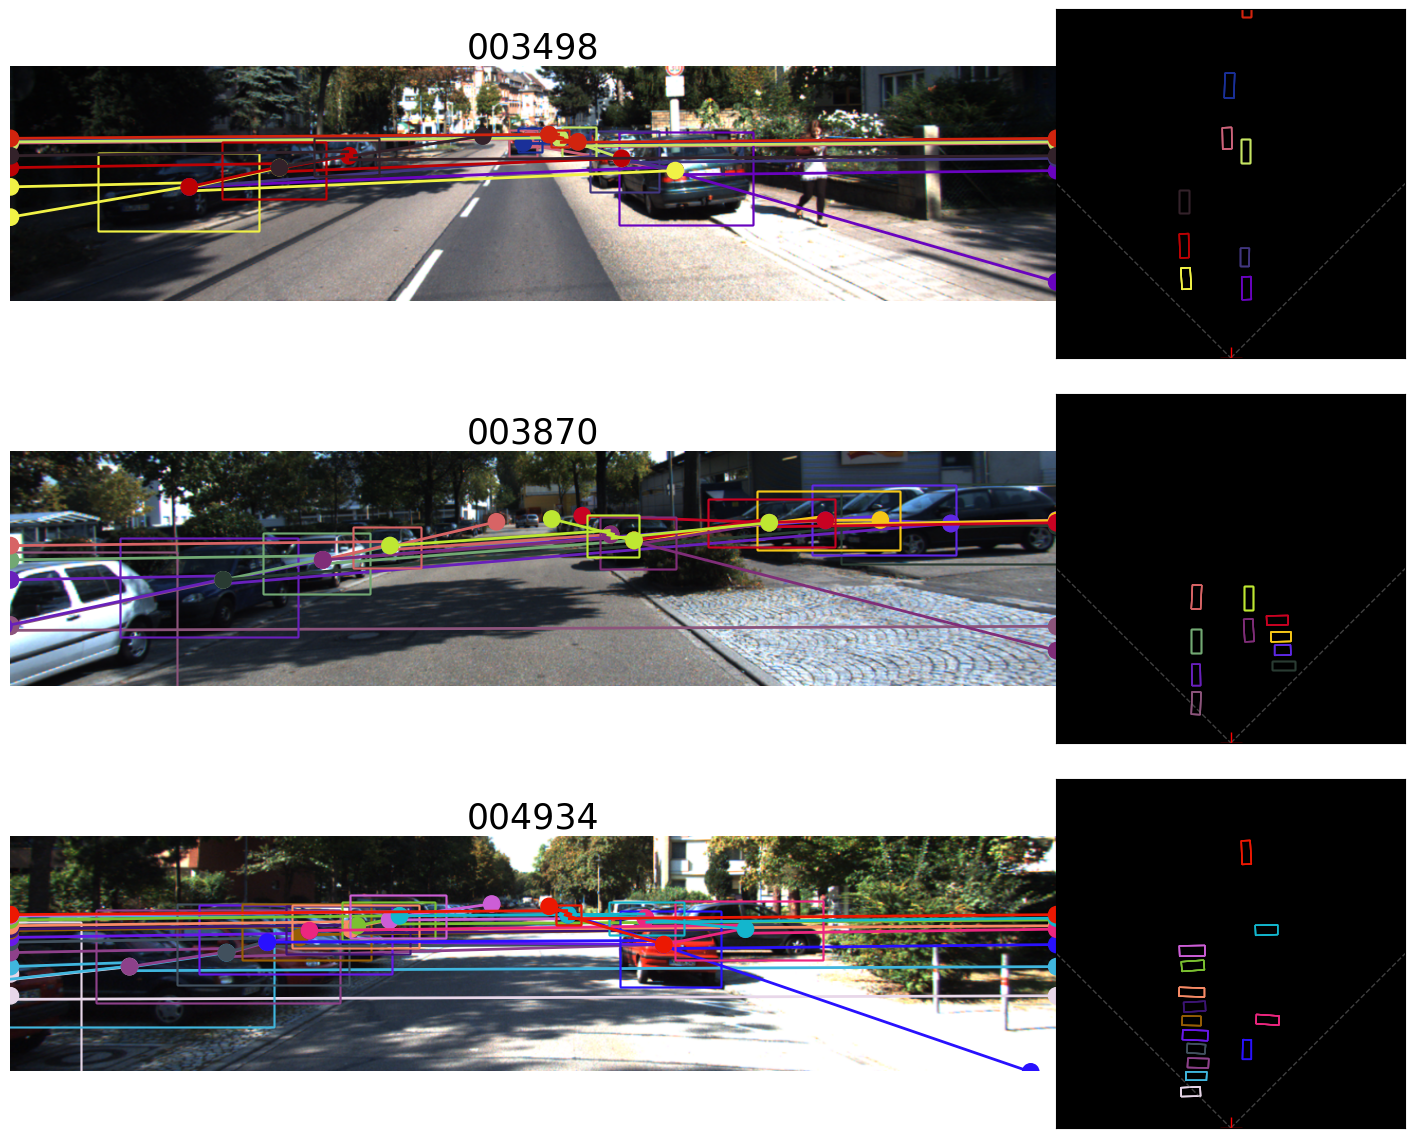

In [16]:

# random.seed(123)
img_names = [i.split('.')[0] for i in os.listdir(ANO_DIR)]

random.shuffle(img_names)

chose_name = img_names[:NUM_IMAGE_SHOW]

# chose_name = ['003308', '000712', '007360', '003993', '001718', '000039', '006050', '000249', '005191', '000631', '006090']
chose_name = ['003498', '003870', '004934']

# Transform image 
chose_img = []
chose_P2  = []
for name in chose_name:
    P2 = kitti_calib_file_parser(os.path.join(CAR_DIR, f"{name}.txt"), new_shape_tf = (288, 1280), crop_tf = 100)
    # img = cv2.imread(os.path.join(IMG_DIR, f"{name}.png"))
    img = load_tf_image(os.path.join(IMG_DIR, f"{name}.png"))
    
    chose_P2.append(P2)
    chose_img.append(img)

axs = init_img_plt(chose_img, titles = chose_name)

for i, img_name in enumerate(chose_name):
    
    objs = kitti_label_file_parser(os.path.join(ANO_DIR, f"{img_name}.txt"), tf_matrix = chose_P2[i])

    # Transform 2D bbox via P2 projection
    [obj.transform_2d_bbox() for obj in objs] # This is for visualizing 2D bounding box
    
    # Filter Non-car Objs
    objs = [obj for obj in objs if obj.category == "Car"]
    
    ###################
    ### Encode NOAM ###
    ###################
    obj_adj_target = noam_encode( np.array( [ [obj.x3d, obj.y3d, obj.z3d, obj.h, obj.w, obj.l] for obj in objs] ), chose_P2[i])

    ###################
    ### Decode NOAM ###
    ###################
    total_h = 288
    total_w = 1280

    for obj_idx in range(len(objs)):
        # Decode
        noam_predi = noam_decode(obj_adj_target[obj_idx, :], 
                                 (objs[obj_idx].cx, objs[obj_idx].cy), 
                                 (288, 1280))
        
        color = [random.random() for _ in range(3)]
        for i_adj in range(4):
            if   i_adj == 0: n = "farer"
            elif i_adj == 1: n = "close"
            elif i_adj == 2: n = "right"
            elif i_adj == 3: n = "lefft"
            
            # Draw line on image
            path = Path(np.array([(objs[obj_idx].cx + jit_img_dict[n][0], objs[obj_idx].cy + jit_img_dict[n][1]), 
                                  (noam_predi[i_adj*2]    , noam_predi[i_adj*2+1])], float), 
                        [Path.MOVETO, Path.LINETO])

            pathpatch = PathPatch(path, fill=False, color=color, linewidth=2)
            axs[i][0].add_patch(pathpatch)
            
            # Draw endpoint on image
            endpoint = patches.Circle((noam_predi[i_adj*2] , noam_predi[i_adj*2+1]), radius=10, color=color)
            axs[i][0].add_patch(endpoint)
            
            # Draw bbox
            draw_2Dbox(axs[i][0], (objs[obj_idx].xmin, objs[obj_idx].ymin, objs[obj_idx].xmax, objs[obj_idx].ymax), color = color)
            draw_birdeyes(axs[i][1], objs[obj_idx], color = color, title = "123", is_print_confident = False)


# Show predict noam offset on image

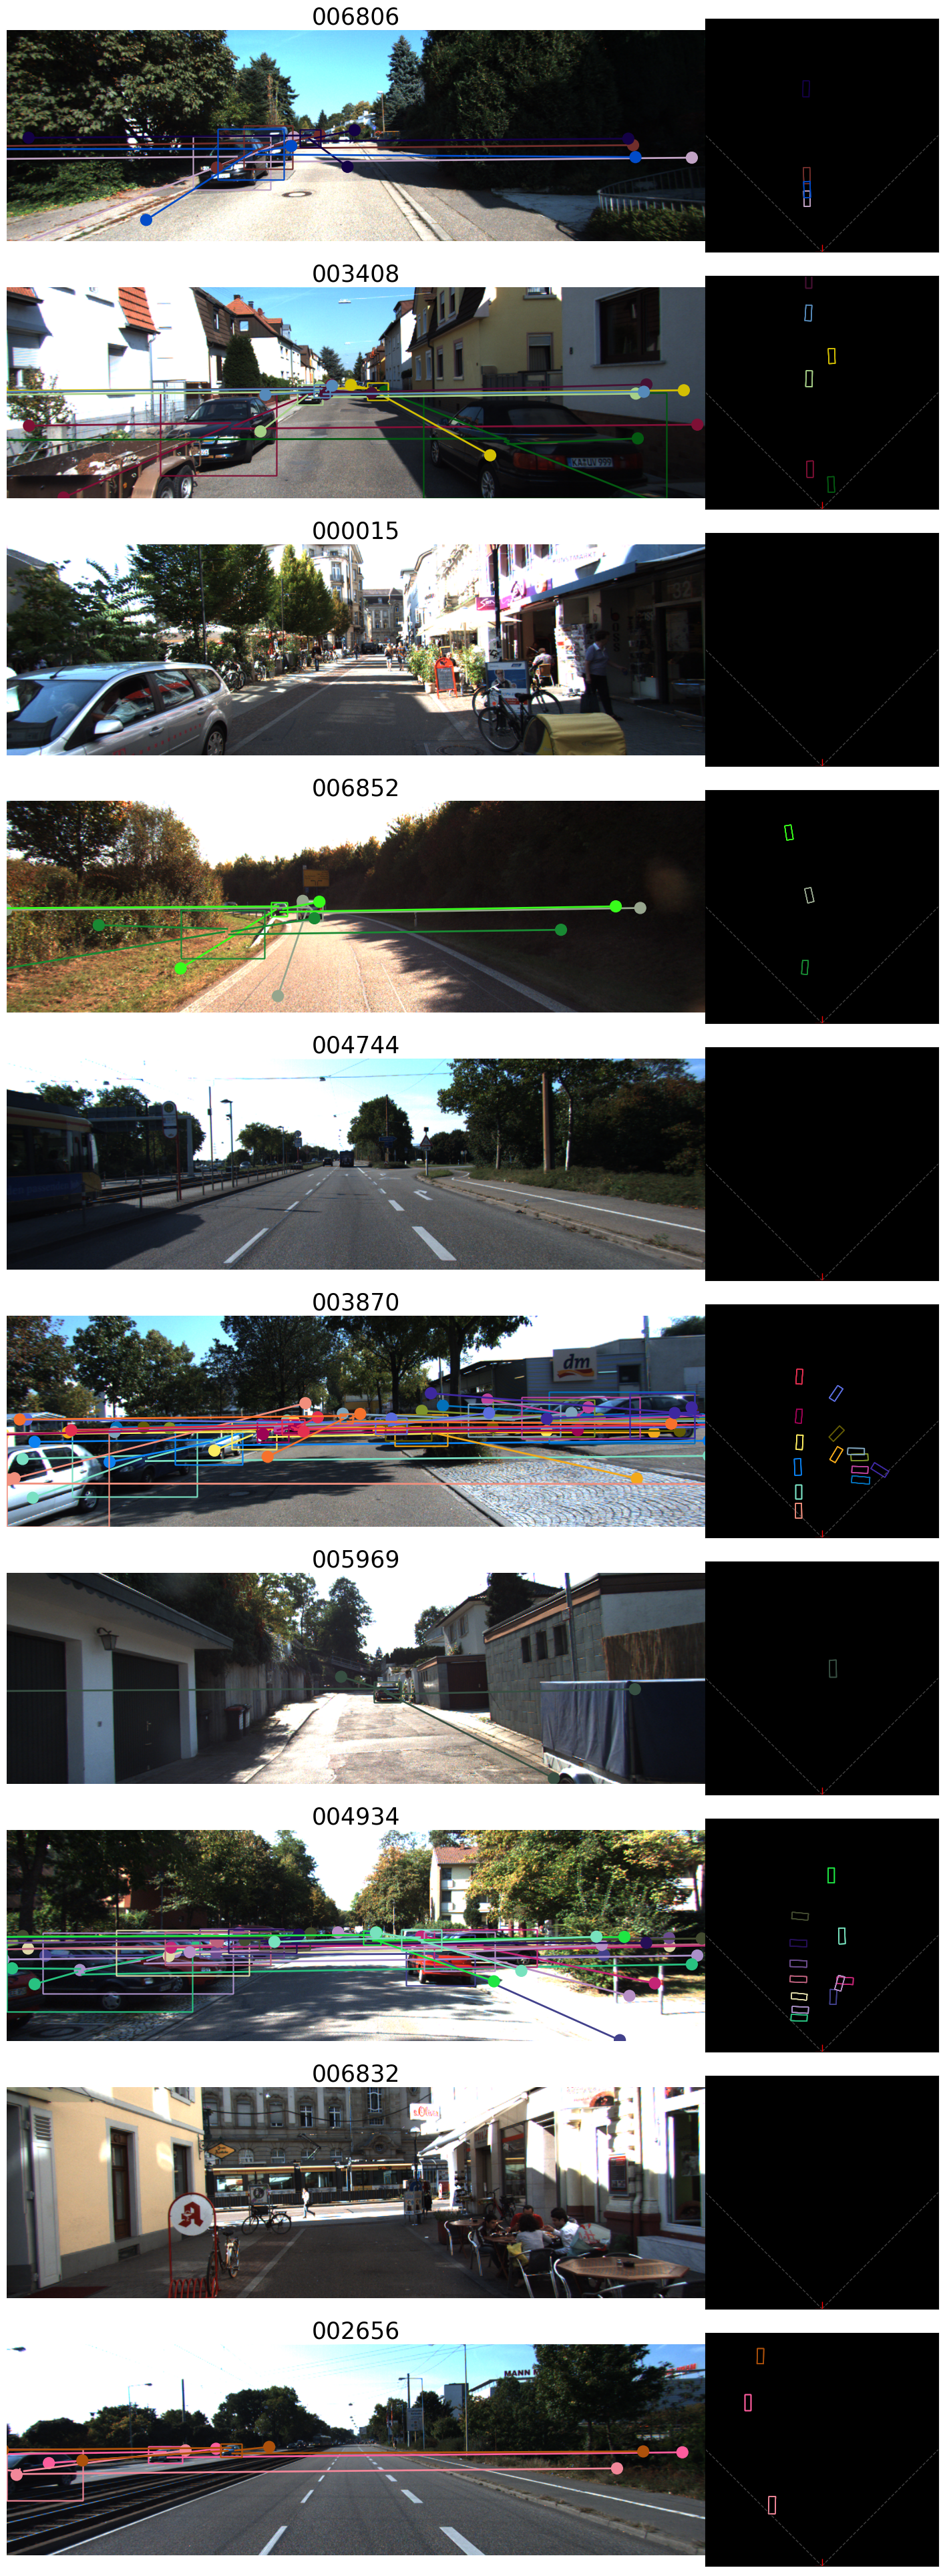

In [15]:
random.seed(123)
NUM_IMAGE_SHOW = 10

img_names = [i.split('.')[0] for i in os.listdir(PRD_DIR)]

random.shuffle(img_names)

chose_name = img_names[:NUM_IMAGE_SHOW]

# Transform image 
chose_img = []
chose_P2  = []
for name in chose_name:
    P2 = kitti_calib_file_parser(os.path.join(CAR_DIR, f"{name}.txt"))
    img = cv2.imread(os.path.join(IMG_DIR, f"{name}.png"))

    chose_P2.append(P2)
    chose_img.append(img)

axs = init_img_plt(chose_img, titles = chose_name)

for i, img_name in enumerate(chose_name):
    
    # objs = kitti_label_file_parser(os.path.join(PRD_DIR, f"{img_name}.txt"), tf_matrix = chose_P2[i])
    with open(os.path.join(PRD_DIR, f"{img_name}.txt")) as f:
        lines = f.read().splitlines()
        lines = list(lines for lines in lines if lines) # Delete empty lines
        
        # original terms 
        lines_orig = [" ".join( line.split()[:-8] ) for line in lines]
        
        # norm terms
        lines_noam = [" ".join( line.split()[-8:] ) for line in lines]
    
    objs =  [KITTI_Object(str_line,
                          idx_img = img_name,
                          idx_line = idx_line, 
                          tf_matrix = chose_P2[i]) for idx_line, str_line in enumerate(lines_orig)]
    noams = np.array([[float(x) for x in l.split()] for l in lines_noam])
    
    # Transform 2D bbox via P2 projection
    # [obj.transform_2d_bbox() for obj in objs] # This is for visualizing 2D bounding box
    
    ###################
    ### Decode NOAM ###
    ###################
    h, w, c = chose_img[i].shape
    for obj_idx in range(len(objs)):
        
        # Decode
        noam_predi = noam_decode(noams[obj_idx, :], (objs[obj_idx].cx, objs[obj_idx].cy), (h, w))
        
        color = [random.random() for _ in range(3)]
        for i_adj in range(4):
            if   i_adj == 0: n = "farer"
            elif i_adj == 1: n = "close"
            elif i_adj == 2: n = "right"
            elif i_adj == 3: n = "lefft"
            
            # Draw line on image
            path = Path(np.array([(objs[obj_idx].cx + jit_img_dict[n][0], objs[obj_idx].cy + jit_img_dict[n][1]), 
                                  (noam_predi[i_adj*2]    , noam_predi[i_adj*2+1])], float), 
                        [Path.MOVETO, Path.LINETO])

            pathpatch = PathPatch(path, fill=False, color=color, linewidth=2)
            axs[i][0].add_patch(pathpatch)
            
            # Draw endpoint on image
            endpoint = patches.Circle((noam_predi[i_adj*2] , noam_predi[i_adj*2+1]), radius=10, color=color)
            axs[i][0].add_patch(endpoint)
            
            # Draw bbox
            draw_2Dbox   (axs[i][0], (objs[obj_idx].xmin, objs[obj_idx].ymin, objs[obj_idx].xmax, objs[obj_idx].ymax), color = color)
            draw_birdeyes(axs[i][1],  objs[obj_idx], color = color, title = "123", is_print_confident = False)
